<h1 style="font-size: 25px; color: blue;">1 - Modified Epileptor-2 : applying the Low-Frequency Electrical Stimulation (LFES) protocol</h1>

<br>Contact: guillaumegirier@gmail.com</br>

<br>Commun work: Guillaume Girier, Isa Dallmer-Zerbe, Helmut Schmidt</br>

In this notebook, we present the Epileptor-2 model and illustrate the various time series it generates under different conditions. We first demonstrate the model’s behavior in the absence of low-frequency electrical stimulation (LFES), providing insights into the baseline seizure dynamics. Subsequently, we introduce LFES into the model and showcase its effects on the time series, highlighting the modulation of seizure activity and the underlying mechanisms at play.

<h1 style="font-size: 25px; color: blue;">Epileptor-2 model :</h1>


### Adapting the model :


This work is inspired by the Epileptor-2 model [1].

We define the differential equation system as follows :

$$
  \tau_m \cdot \frac{dV}{dt} = u(V,xD,Ko)-gl \cdot V+ I_{syn} + I_{ext}\\
$$
$$
  \frac{dxD}{dt} = \frac{(1-xD)}{\tau_x} - \delta_x \cdot xD \cdot vi(V) \\
$$
$$
  \frac{dKo}{dt} = \frac{Kbath-Ko}{\tau_{Ko}} -2 \cdot \gamma \cdot Ipump(Ko,Na)+ delta_{Ko} \cdot vi(V)\\
$$
$$
  \frac{dNai}{dt} = \frac{Nai_0-Nai}{\tau_{Nai}} -3 \cdot Ipump(Ko,Nai)+delta_{Nai} \cdot vi(V) \\
$$

where Ko and Nai represent extracellular potassium and intraneuronal sodium concentrations, respectively; V is the membrane depolarization; xD is the synaptic resource; vi(t) is the firing rate of an excitatory population. We define the additional equations as follows :

$$
    vi(V) = vmax \cdot \frac{1}{1+e^{Vth-V}}\\
$$
$$
    u(V,xD,Ko) = gK\cdot 26.6\cdot \log(\frac{Ko}{Ko0})+G_{syn}\cdot vi(V)\cdot (xD-0.5)+ \sigma \cdot  \xi \\
$$
$$
    Ipump(Ko,Nai) =  \frac{\rho}{(1+e^{3.5-Ko})\cdot(1+e^{(25.0-Nai)/3})} \\
$$

where $\xi$ is random samples from a normal (Gaussian) distribution. (contain between 0 and 1)

### Adding the inhibitory current :

To show the delay between ictal phases, and therefore the phenomenon of depolarization during stimulation, then repolarization at the end of the spike train, we add an additional inhibitory term $I_{syn}$ defined as follows [2]:

$$
    Isyn = g \cdot S_i \cdot (V_{syn} - V)
$$

We suppose the existence of a passive population connected to the studied excitatory population, with the conductance, $g$, and a gating parameter, $S_i$.

### References :

[1] Chizhov AV, Zefirov AV, Amakhin DV, Smirnova EY, Zaitsev AV (2018) Minimal model of interictal and ictal discharges “Epileptor-2”. PLOS Computational Biology 14(5): e1006186. https://doi.org/10.1371/journal.pcbi.1006186

[2] Börgers, C., Krupa, M. & Gielen, S. The response of a classical Hodgkin–Huxley neuron to an inhibitory input pulse. J Comput Neurosci 28, 509–526 (2010). https://doi.org/10.1007/s10827-010-0233-8


<h1 style="font-size: 25px; color: blue;">Library importations :</h1>


In [1]:
#%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

<h1 style="font-size: 25px; color: blue;">Defining functions :</h1>

<h1 style="font-size: 22px; color: red;"> LFES spike train function :</h1>


In [2]:
def generate_periodic_spike_train(total_time, spike_count, dt):
    time = np.arange(0, total_time, dt)
    spike_train = np.zeros_like(time)

    # Calculer les intervalles entre chaque train de spike
    inter_spike_interval = int(1/(dt*Hz))

    # Générer les trains de spikes
    for i in range(spike_count):
        spike_train[i * inter_spike_interval] = 1

    return spike_train

<h1 style="font-size: 22px; color: red;"> Epileptor-2 model function :</h1>


In [3]:
# Epileptor-2 parameter values

Kbath=8.5
gamma=10.0
deltaKo=0.02
deltaNai=0.03
Ko0=3.0
Nai0=10.0

factor = 1.75
tauK=10.0*factor
tauNa=20.0*factor
rho=0.2/factor
taum=0.002  
taux=2.0
deltax=0.01

G_syn=0.3
vmax= 75.0

Vth=10.0

gle=1.0
gKe=0.5

##############################

# Noise activation : 0/1

sigma=0


##############################

# Connection with the inactive population

I0 = 0
Vsyn = -15
Ssyn = 1
gsyn = 0.1686

##############################

# Setting the stimulation time

Hz = 1
A = 30
stim_size = 100
space = 59
ini_1 = 365.5
ini_2 = ini_1 + stim_size

##############################

# Define auxiliary functions

def         vi(V): return vmax*1./(1+np.exp(Vth-V))
def    ue(V,xD,Ko): return gKe*26.6*np.log(Ko/Ko0)+G_syn*vi(V)*xD+ sigma * np.random.normal(0, 1) 
def Ipump(Ko,Nai): return rho/((1+np.exp(3.5-Ko))*(1+np.exp((25.0-Nai)/3)))

##############################

# Main function

def my_epileptor_2(t_eval, dt, ini):
    
       
    Ve  = np.zeros(len(t_eval))
    xDe = np.zeros(len(t_eval))
    Koe = np.zeros(len(t_eval))
    Naie= np.zeros(len(t_eval))
    IPUMP = np.zeros(len(t_eval))
    VI = np.zeros(len(t_eval))
    
    I  = np.zeros(len(t_eval))
    UPS = np.zeros(len(t_eval))
    
    Ve[0]  =ini[0]
    xDe[0] =ini[1]
    Koe[0] =ini[2]
    Naie[0]=ini[3]
    UPS[0] = vi(Ve[0])
    
    for i in range(1, len(t_eval)):
        
        if statut == True:
            if t_eval[i]>ini_1 and t_eval[i]<ini_2:
                I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space and t_eval[i]<ini_2+space:
            #    I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space*2 and t_eval[i]<ini_2+space*2:
            #    I[i]  = A*Itrain[i]
            #elif t_eval[i]>ini_1+space*3 and t_eval[i]<ini_2+space*3:
            #    I[i]  = A*Itrain[i]
            else:
                I[i]  = 0
        else:
            I[i]  = 0
            
        
            
        Isyne = gsyn * Ssyn * (Vsyn - Ve[i-1])
        IPUMP[i] = Ipump(Koe[i-1],Naie[i-1])
    
        Ve[i]  = Ve[i-1] + dt *( (ue(Ve[i-1],xDe[i-1],Koe[i-1])-gle*Ve[i-1]+ Isyne +I[i-1])/taum  )
        xDe[i] = xDe[i-1] + dt *( (1-xDe[i-1])/taux-deltax*xDe[i-1]*vi(Ve[i-1]) )
        Koe[i] = Koe[i-1] + dt * ( (Kbath-Koe[i-1])/tauK-2*gamma*Ipump(Koe[i-1],Naie[i-1])+deltaKo*vi(Ve[i-1]))
        Naie[i]= Naie[i-1] + dt * ( (Nai0-Naie[i-1])/tauNa-3*Ipump(Koe[i-1],Naie[i-1])+deltaNai*vi(Ve[i-1]) )
        UPS[i] = vi(Ve[i-1])
                
    return np.array([Ve, xDe, Koe, Naie, I, UPS, IPUMP])

<h1 style="font-size: 25px; color: blue;">Simulations :</h1>

<h1 style="font-size: 22px; color: red;"> Model without LFES effect simulation :</h1>


In [4]:
S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
t_span = (0, 1000)                            # Time span for simulation
dt=0.001
statut = False                                # Choosing if we apply or not the LFES : True = LFES / False = no LFES
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
sol = my_epileptor_2(t_eval, dt, S0)          # Simulation


<h1 style="font-size: 22px; color: red;"> Saving the time series into variables:</h1>


In [5]:
VVe_ref = sol[0]
XXe_ref = sol[1]
KKe_ref = sol[2]
NNae_ref = sol[3]
I_ref = sol[4]
UPS_ref = sol[5]
IPUMP_ref = sol[6]
T_ref = t_eval

<h1 style="font-size: 22px; color: red;"> Generating the LFES time series to apply :</h1>


In [6]:
# Paramètres
total_time_spike = 20    # Total duration of the spike train in seconds
total_time_no = 4        # Total duration of the silent time
spike_count = 20*Hz      # Spike number in each spike train

# Generating the spike train
spike_train = generate_periodic_spike_train(total_time_spike, spike_count, dt)
TIME = total_time_spike*2 + total_time_no*0
action_potential_ts = np.hstack((spike_train, spike_train,))

#########################################################

for j in range(100):
    TIME += total_time_spike*1 + total_time_no*0
    action_potential_ts = np.hstack((action_potential_ts, np.hstack((spike_train,))))


Itrain = action_potential_ts[:len(t_eval)]
new_TIME = np.arange(0, TIME, dt)[:len(t_eval)]


<h1 style="font-size: 22px; color: red;"> Model with LFES effect simulation :</h1>


In [7]:
S0=np.array([25.0, 0.7, 3.0, 5.0])            # Initial conditions : V, xD, Ko, Na 
t_span = (0, 1000)                            # Time span for simulation
dt=0.001
statut = True                                 # Choosing if we apply or not the LFES : True = LFES / False = no LFES
t_eval = np.arange(t_span[0], t_span[1], dt)  # Time points to evaluate
sol = my_epileptor_2(t_eval, dt, S0)          # Simulation


<h1 style="font-size: 22px; color: red;"> Saving the time series into variables :</h1>


In [8]:

VVe1 = sol[0]
XXe1 = sol[1]
KKe1 = sol[2]
NNae1 = sol[3]
I1 = sol[4]
UPS = sol[5]
IPUMP1 = sol[6]
T1 = t_eval

<h1 style="font-size: 25px; color: blue;">Plotting the results :</h1>

<h1 style="font-size: 22px; color: red;"> No LFES case :</h1>


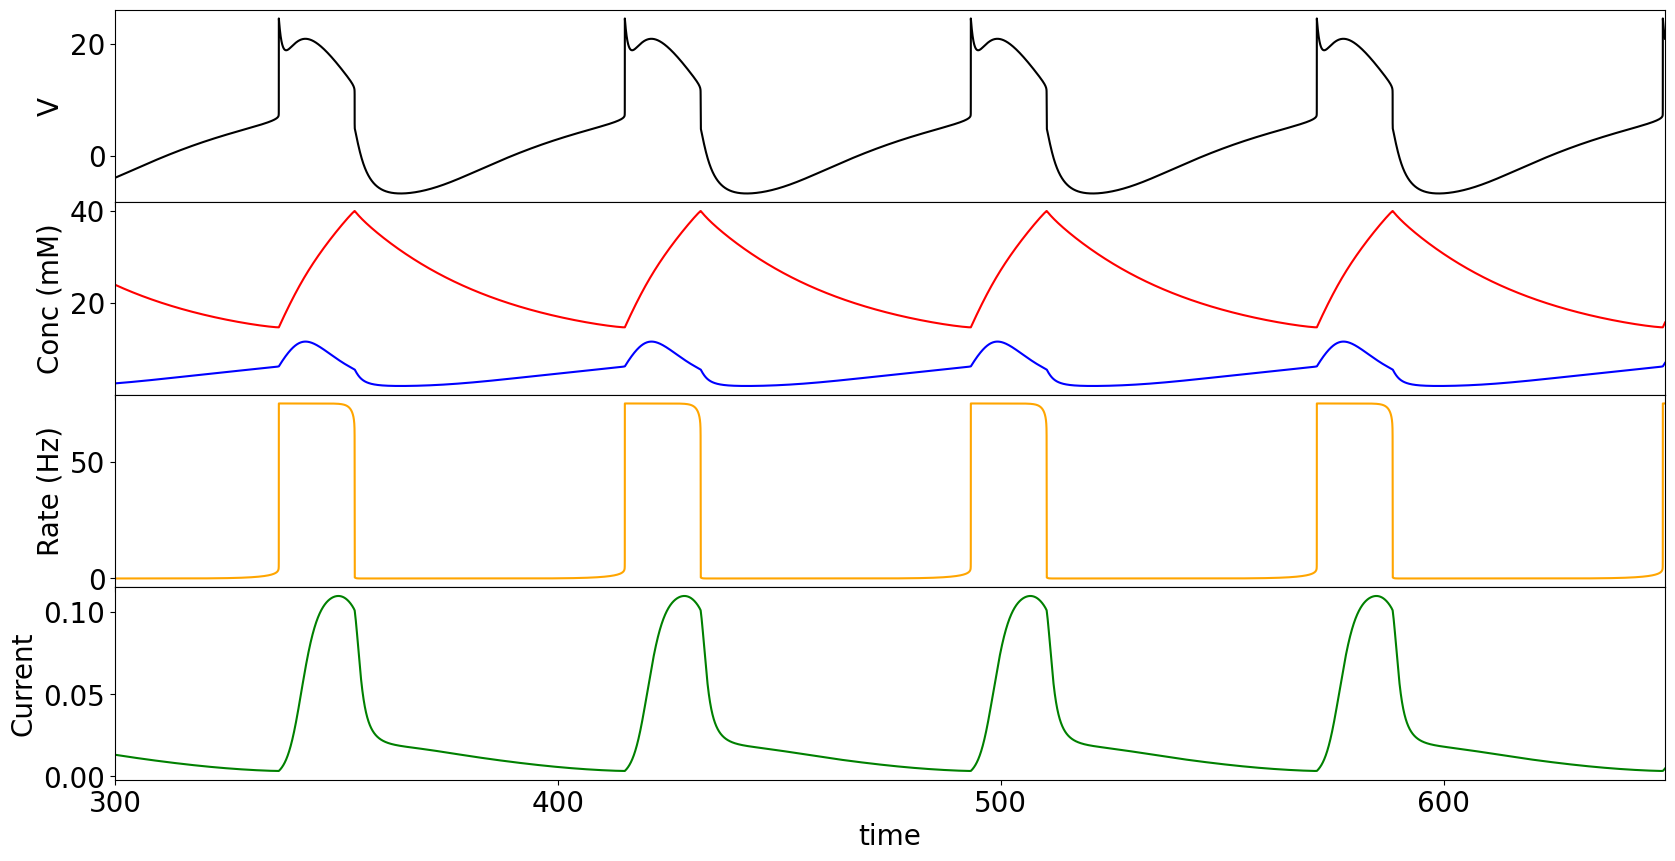

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(T_ref[100000:], VVe_ref[100000:], 'k')
axs[1].plot(T_ref[100000:], KKe_ref[100000:], 'b')
axs[1].plot(T_ref[100000:], NNae_ref[100000:], 'r')
axs[2].plot(T_ref[100000:], UPS_ref[100000:], 'orange')
axs[3].plot(T_ref[100000:], IPUMP_ref[100000:], 'green')
#axs[3].plot(new_TIME_2,A*action_potential_ts_2, "b")

plt.xlim([300, 650])
#plt.ylim([-300, 50])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)

axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
xLabel = axs[0].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[0].set_ylabel('V',  rotation=90, linespacing=3, fontsize=20)

axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
xLabel = axs[1].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[1].set_ylabel('Conc (mM)',  rotation=90, linespacing=3, fontsize=20)

axs[2].tick_params(axis='x', labelsize=20)
axs[2].tick_params(axis='y', labelsize=20)
xLabel = axs[2].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[2].set_ylabel('Rate (Hz)',  rotation=90, linespacing=3, fontsize=20)

axs[3].tick_params(axis='x', labelsize=20)
axs[3].tick_params(axis='y', labelsize=20)
xLabel = axs[3].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[3].set_ylabel('Current',  rotation=90, linespacing=3, fontsize=20)

plt.savefig('FIG_2_D.eps', format='eps', dpi=300)

axs[0].dist = 10
plt.show() 

<h1 style="font-size: 22px; color: red;"> LFES case :</h1>


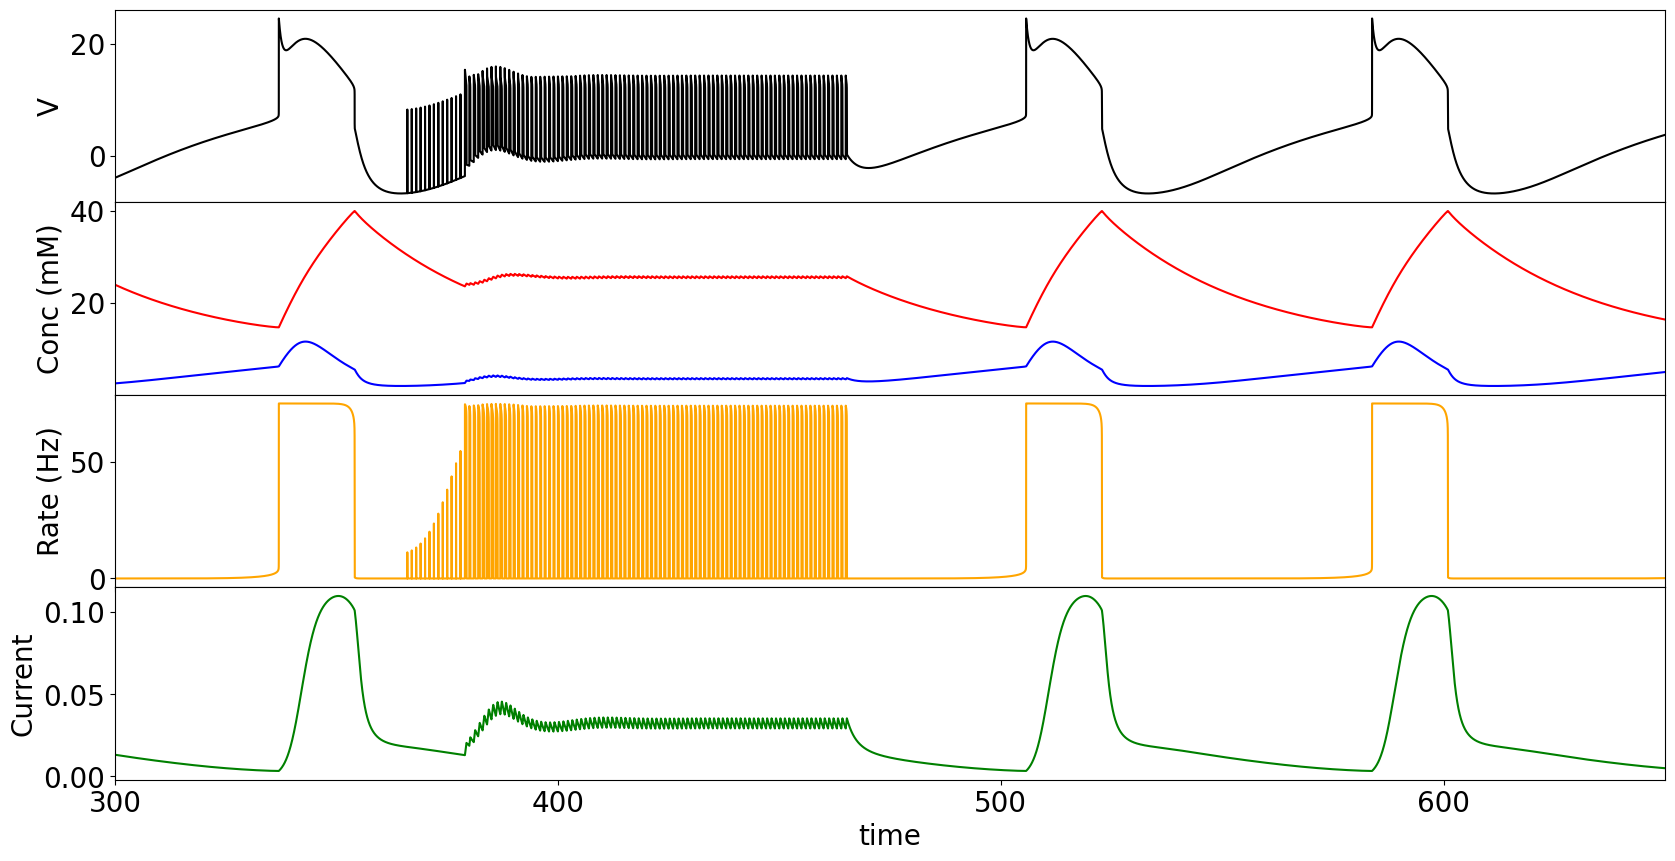

In [10]:
%matplotlib inline

fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(4, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].plot(T_ref[100000:], VVe1[100000:], 'k')
axs[1].plot(T_ref[100000:], KKe1[100000:], 'b')
axs[1].plot(T_ref[100000:], NNae1[100000:], 'r')
axs[2].plot(T_ref[100000:], UPS[100000:], 'orange')
axs[3].plot(T_ref[100000:], IPUMP1[100000:], 'green')
#axs[3].plot(new_TIME_2,A*action_potential_ts_2, "b")


#plt.ylim([-300, 50])
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=4)

axs[0].tick_params(axis='x', labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
xLabel = axs[0].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[0].set_ylabel('V',  rotation=90, linespacing=3, fontsize=20)

axs[1].tick_params(axis='x', labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
xLabel = axs[1].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[1].set_ylabel('Conc (mM)',  rotation=90, linespacing=3, fontsize=20)

axs[2].tick_params(axis='x', labelsize=20)
axs[2].tick_params(axis='y', labelsize=20)
xLabel = axs[2].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[2].set_ylabel('Rate (Hz)',  rotation=90, linespacing=3, fontsize=20)

axs[3].tick_params(axis='x', labelsize=20)
axs[3].tick_params(axis='y', labelsize=20)
xLabel = axs[3].set_xlabel('time', linespacing=3, fontsize=20)
yLabel = axs[3].set_ylabel('Current',  rotation=90, linespacing=3, fontsize=20)
plt.xlim([300, 650])

plt.savefig('FIG_2_B.eps', format='eps', dpi=300)

axs[0].dist = 10
plt.show() 